# Load Packages and Data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [5]:
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
profile = pd.read_json(r'data\01_raw\profile.json', lines=True)
transcript = pd.read_json(r'data\01_raw\transcript.json', lines=True)

# Portfolio Data

In [6]:
"""
portfolio.json
Offers sent during 30-day test period (10 offers x 6 fields)
    id (string) - offer id
    offer_type (string) - type of offer ie BOGO, discount, informational
    difficulty (int) - minimum required spend to complete an offer
    reward (int) - reward given for completing an offer
    duration (int) - time for offer to be open, in days
    channels (list of strings)
"""

# Load each JSON file into a pandas DataFrame
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## Featurize the 'channels' column

In [7]:
# Convert 'channels' column into a string of space-separated strings
portfolio['channels'] = portfolio['channels'].apply(lambda x: ' '.join(x))

# Convert 'channels' column into separate binary columns
channels_profile = portfolio['channels'].str.get_dummies(' ')

# Concatenate the original DataFrame with the new 'channels' DataFrame
portfolio = pd.concat([portfolio, channels_profile], axis=1)

# Drop the original 'channels' column
portfolio = portfolio.drop('channels', axis=1)

# Rename the 'id' column to 'offer_id'
portfolio = portfolio.rename(columns={'id': 'offer_id'})

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## Summary

In [8]:
#Count of offer_ids
num_offers = portfolio['offer_id'].nunique()

#Count of offer types
offer_types = portfolio['offer_type'].nunique()

#Create a list of offer types
offer_type_list = portfolio['offer_type'].unique()

#Convert to a offer_type_list to a string
offer_type_list = ', '.join(offer_type_list)

print("The dataset contains {} unique offers that consists of {} different offer types: {}.".
      format(num_offers, offer_types, offer_type_list))

print("The offers were sent through email, mobile, social and web channels.")

#Min and Max difficulty
min_difficulty = portfolio['difficulty'].min()
max_difficulty = portfolio['difficulty'].max()

#Min and Max reward
min_reward = portfolio['reward'].min()
max_reward = portfolio['reward'].max()

print("Customers were prompted to spend from {} to {} dollars with the rewards ranging from {} to {} dollars"
      .format(min_difficulty, max_difficulty, min_reward, max_reward))

The dataset contains 10 unique offers that consists of 3 different offer types: bogo, informational, discount.
The offers were sent through email, mobile, social and web channels.
Customers were prompted to spend from 0 to 20 dollars with the rewards ranging from 0 to 10 dollars


## Featurize offer_types

In [9]:
# Convert the offer_type column into separate binary columns
offer_type_profile = pd.get_dummies(portfolio['offer_type'], prefix='offer_type')

# Convert True/False values to 1/0
offer_type_profile = offer_type_profile.astype(int)

# Concatenate the original DataFrame with the new 'offer_type' DataFrame
portfolio = pd.concat([portfolio, offer_type_profile], axis=1)

# Drop the original 'offer_type' column
portfolio = portfolio.drop('offer_type', axis=1)

#Make the offer_id the first column in the dataframe
cols = ['offer_id'] + [col for col in portfolio if col != 'offer_id']
portfolio = portfolio[cols]

portfolio.head()

,offer_id,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0


## Graph offer_types and channels

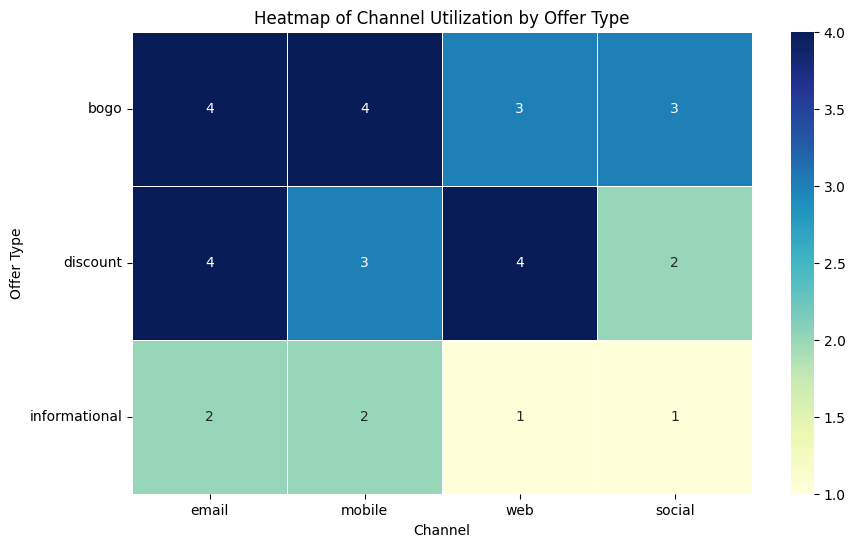

In [10]:
# Create a new DataFrame to summarize the channel utilization by offer type
channel_utilization = portfolio[['offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'email', 'mobile', 'social', 'web']]

# Group by offer type and sum the channels
channel_utilization_summary = channel_utilization.groupby(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']).sum()

# Reset index to make the DataFrame easier to handle
channel_utilization_summary.reset_index(inplace=True)

# Map offer type columns to a single 'offer_type' column for easier plotting
channel_utilization_summary['offer_type'] = channel_utilization_summary.apply(
    lambda row: 'bogo' if row['offer_type_bogo'] == 1 else ('discount' if row['offer_type_discount'] == 1 else 'informational'), axis=1)

# Drop the offer type indicator columns
channel_utilization_summary.drop(columns=['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], inplace=True)

# Set 'offer_type' as the index
channel_utilization_summary.set_index('offer_type', inplace=True)

# Sum the rows and columns, sort them in descending order, and reorder the DataFrame based on these sums
row_sums = channel_utilization_summary.sum(axis=1).sort_values(ascending=False)
col_sums = channel_utilization_summary.sum(axis=0).sort_values(ascending=False)
channel_utilization_summary = channel_utilization_summary.loc[row_sums.index, col_sums.index]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(channel_utilization_summary, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)

plt.title('Heatmap of Channel Utilization by Offer Type')
plt.xlabel('Channel')
plt.ylabel('Offer Type')

# Rotate y-axis labels
plt.yticks(rotation=0)

plt.show()

## Export Featurized Data

In [11]:
#Export the cleaned data to .csv
portfolio.to_csv(r'data\02_stg\stg_portfolio.csv', index=False)

#Pickle the cleaned data
portfolio.to_pickle(r'data\02_stg\stg_portfolio.pkl')

# Profile Data

In [12]:
"""
profile.json
Rewards program users (17000 users x 5 fields)
Details the different offers sent during the test period, including offer type (buy-one-get-one, discount, informational), reward amount, required spending threshold, duration, and delivery channels.
    age (int) - age of the customer (missing value is encoded as 118)
    became_member_on (int) - date when customer created an app account
    gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    id (str) - customer id
    income (float) - customer's income

"""
### Clean up the profile data ###
# Rename the 'id' column to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

#make customer id the first column
cols = ['customer_id'] + [col for col in profile if col != 'customer_id']
profile = profile[cols]

#Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Calculate membership duration in days from the max date in the dataset
profile['days_as_member'] = (profile['became_member_on'].max()- profile['became_member_on']).dt.days

# Replace None with NaN
profile['gender'] = profile['gender'].fillna(np.nan)

# Replace 118 with NaN
profile['age'] = profile['age'].replace(118, np.nan)

# Save the cleaned data 
profile.to_csv(r'data\02_stg\stg_profile.csv', index=False)
profile.to_pickle(r'data\02_stg\stg_profile.pkl')

profile.head()

,customer_id,gender,age,became_member_on,income,days_as_member
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,2017-02-12,NaN,529
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,376
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,2018-07-12,NaN,14
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,443
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,2017-08-04,NaN,356


In [13]:
#Split the data set into two dataframes. One with missing values and one without
#Create the dataframe with missing values
profile_missing = profile[profile.isnull().any(axis=1)]
profile_missing = profile.reset_index(drop=True)\

#Export the dataframes to .csv and .pkl
profile_missing.to_csv(r'data\03_int\int_profile_missing.csv', index=False)
profile_missing.to_pickle(r'data\03_int\int_profile_missing.pkl')

#Create the dataframe without missing values
profile_clean = profile.dropna()
profile_clean = profile_clean.reset_index(drop=True)

#Export the dataframes to .csv and .pkl
profile_clean.to_csv(r'data\03_int\int_profile_clean.csv', index=False)
profile_clean.to_pickle(r'data\03_int\int_profile_clean.pkl')

profile_clean.head()

,customer_id,gender,age,became_member_on,income,days_as_member
0,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,376
1,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,443
2,e2127556f4f64592b11af22de27a7932,M,68.0,2018-04-26,70000.0,91
3,389bc3fa690240e798340f5a15918d5c,M,65.0,2018-02-09,53000.0,167
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,2017-11-11,51000.0,257


## Summary

### Data Density

In [14]:
# Percentage of missing values in each column
nan_percent = round(profile.isna().mean() * 100, 2)
print(nan_percent)

customer_id          0.00
gender              12.79
age                 12.79
became_member_on     0.00
income              12.79
days_as_member       0.00
dtype: float64


### Data Distribution

In [15]:
# For profile[['days_as_member', 'age', 'income']], call the describe method and then transpose the results
profile_statistics = profile[['days_as_member', 'age', 'income']].describe().astype(int)

#Add a row that calculates the range for each column
profile_range = (profile[['days_as_member', 'age', 'income']].max() - profile[['days_as_member', 'age', 'income']].min()).astype(int)
profile_range = profile_range.to_frame().T
profile_range.index = ['range']

#Concatenate the two DataFrames
profile_statistics = pd.concat([profile_statistics, profile_range]).T

#Save cleaned data to .csv
profile_statistics.to_csv(r'data\04_fct\fct_profile_statistics.csv', index=False)

profile_statistics.head()

,count,mean,std,min,25%,50%,75%,max,range
days_as_member,17000,517,411,0,208,358,791,1823,1823
age,14825,54,17,18,42,55,66,101,83
income,14825,65404,21598,30000,49000,64000,80000,120000,90000


In [16]:
# Calculate value counts
gender_counts = profile['gender'].value_counts(dropna=False).to_frame().reset_index()
gender_counts.columns = ['Gender', 'Count']

# Calculate percentages
gender_percentages = profile['gender'].value_counts(normalize=True, dropna=False).mul(100).round(2).to_frame().reset_index()
gender_percentages.columns = ['Gender', 'Percentage']

# Merge the two DataFrames
gender_stats = pd.merge(gender_counts, gender_percentages, on='Gender')
gender_stats

,Gender,Count,Percentage
0,M,8484,49.91
1,F,6129,36.05
2,NaN,2175,12.79
3,O,212,1.25


Interesting! Why are there 13.86% more men signed up for the rewards program?

## Segmenting Customers

### Categorize Data

In [17]:
#Create age categories
bins = [18, 25, 35, 45, 55, 65, 75, 102]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)
profile = profile.drop('age', axis=1)

#Create income categories
bins = [30000, 50000, 75000, 100000, 120001]
labels = ['<50K', '50K-74K', '75K-99K', '100K+']
profile['income_group'] = pd.cut(profile['income'], bins=bins, labels=labels, right=False)
profile = profile.drop('income', axis=1)

# Convert 'became_member_on' to datetime if it's not already
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

# Extract the quarter and year from the 'became_member_on' date
profile['membership_quarter'] = profile['became_member_on'].dt.quarter
profile['membership_year'] = profile['became_member_on'].dt.year

# Combine the quarter and year into a single column
profile['member_since'] = profile['membership_year'].astype(str) + ' Q' + profile['membership_quarter'].astype(str)

# Drop the 'days_as_member', 'became_member_on', 'membership_quarter', and 'membership_year' columns
profile = profile.drop(['days_as_member', 'became_member_on', 'membership_quarter', 'membership_year'], axis=1)

#Split the data set into two dataframes. One with missing values and one without
#Create the dataframe with missing values
cat_profile_missing = profile[profile.isnull().any(axis=1)]
cat_profile_missing = cat_profile_missing.reset_index(drop=True)\

#Export the dataframes to .csv and .pkl
cat_profile_missing.to_csv(r'data\03_int\int_cat_profile_missing.csv', index=False)
cat_profile_missing.to_pickle(r'data\03_int\int_cat_profile_missing.pkl')

#Create the dataframe without missing values
cat_profile_clean = profile.dropna()
cat_profile_clean = cat_profile_clean.reset_index(drop=True)

#Export the dataframes to .csv and .pkl
cat_profile_clean.to_csv(r'data\03_int\int_cat_profile_clean.csv', index=False)
cat_profile_clean.to_pickle(r'data\03_int\int_cat_profile_clean.pkl')

cat_profile_clean.head()

,customer_id,gender,age_group,income_group,member_since
0,0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,2017 Q3
1,78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,2017 Q2
2,e2127556f4f64592b11af22de27a7932,M,65-74,50K-74K,2018 Q2
3,389bc3fa690240e798340f5a15918d5c,M,65-74,50K-74K,2018 Q1
4,2eeac8d8feae4a8cad5a6af0499a211d,M,55-64,50K-74K,2017 Q4


In [18]:
# Group by the categorical variables and count the number of customer_ids
cat_vars = ['gender', 'age_group', 'income_group', 'member_since']
max_seg = cat_profile_clean.groupby(cat_vars, observed=True)['customer_id'].count()

# Convert the max_seg data to a DataFrame and reset the index
df_max_seg = max_seg.reset_index()

# Rename the customer_id column to count
df_max_seg.rename(columns={'customer_id': 'cust_count'}, inplace=True)
df_max_seg = df_max_seg.sort_values('cust_count', ascending=False)

# Save the data to a .csv file
df_max_seg.to_csv(r'data\04_fct\fct_profiles_by_income_quarter.csv', index=False)

df_max_seg.head()

,gender,age_group,income_group,member_since,cust_count
629,M,45-54,50K-74K,2017 Q4,128
705,M,55-64,50K-74K,2017 Q3,110
707,M,55-64,50K-74K,2018 Q1,98
782,M,65-74,50K-74K,2017 Q4,98
631,M,45-54,50K-74K,2018 Q2,98


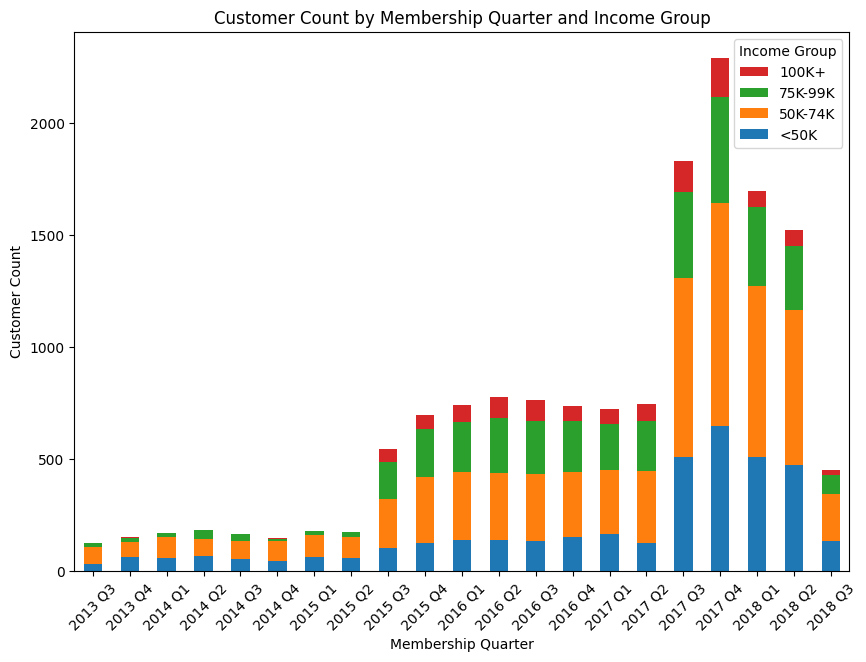

In [19]:
# Aggregate the data
df_agg = df_max_seg.groupby(['member_since', 'income_group'], observed=True)['cust_count'].sum().reset_index()

# Pivot the DataFrame so that each income group is a separate column
df_pivot = df_agg.pivot(index='member_since', columns='income_group', values='cust_count')

# Plot a stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10,7))

# Angle the x-axis labels
plt.xticks(rotation=45)

# Sort the legend in descending order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Income Group')

# Add a title and labels for the x and y axes
plt.title('Customer Count by Membership Quarter and Income Group')
plt.xlabel('Membership Quarter')
plt.ylabel('Customer Count')

# Show the plot
plt.show()

### KModes: Determining Clusters
Note: We cannot use the Silhouette score to help determine the optimal number of clusters because we cannot calculate Euclidean distances using categorical data. 

In [63]:
def calculate_cluster_costs(data, max_clusters):
    """
    This function generates the cost for each number of clusters using the KModes algorithm.
    The cost is defined as the sum of the distances of all data points to their respective cluster centroids.
    The cost derivates are calculated to determine the optimal number of clusters.
    - First derivative (Rate of change): Change in Cost
    - Second derivative (Acceleration): Rate of Change of Change in Cost
    """
    np.random.seed(42)  # Set the seed outside the loop
    costs = []
    
    # Calculate costs for each number of clusters
    for num_clusters in range(1, max_clusters+1):
        km = KModes(n_clusters=num_clusters, init='Huang', n_init=5, verbose=0)
        clusters = km.fit_predict(data)
        costs.append(km.cost_)
    
    # Create a DataFrame
    kmodes_cost = pd.DataFrame({
        'k': range(1, max_clusters+1),
        'cost': costs
    })
    
    # Calculate the difference in costs and insert NaN at the beginning
    kmodes_cost['change_in_cost'] = np.insert(np.diff(costs), 0, np.nan)
    
    # Calculate the percent change in cost
    kmodes_cost['percent_change'] = kmodes_cost['cost'].pct_change() * 100
    
    # Calculate the second derivative
    kmodes_cost['change_in_cost_acceleration'] = kmodes_cost['percent_change'].diff() / kmodes_cost['k'].diff()

    return kmodes_cost

#Set the customer_id as the index of cat_profile_clean so that it doesn't get included in the clustering
cat_profile_clean = cat_profile_clean.set_index('customer_id')

#Calculate the cost for each number of clusters
kmodes_cost = calculate_cluster_costs(cat_profile_clean, 10)

#Save to .csv
kmodes_cost.to_csv(r'data\04_fct\fct_profile_kmodes_cost.csv', index=False)
kmodes_cost

,k,cost,change_in_cost,percent_change,change_in_cost_acceleration
0,1,48473.0,NaN,NaN,NaN
1,2,38580.0,-9893.0,-20.409300,NaN
2,3,30581.0,-7999.0,-20.733541,-0.324241
3,4,27441.0,-3140.0,-10.267813,10.465727
4,5,26541.0,-900.0,-3.279764,6.988049
5,6,26595.0,54.0,0.203459,3.483223
6,7,24750.0,-1845.0,-6.937394,-7.140853
7,8,23272.0,-1478.0,-5.971717,0.965677
8,9,23378.0,106.0,0.455483,6.427200
9,10,22634.0,-744.0,-3.182479,-3.637962


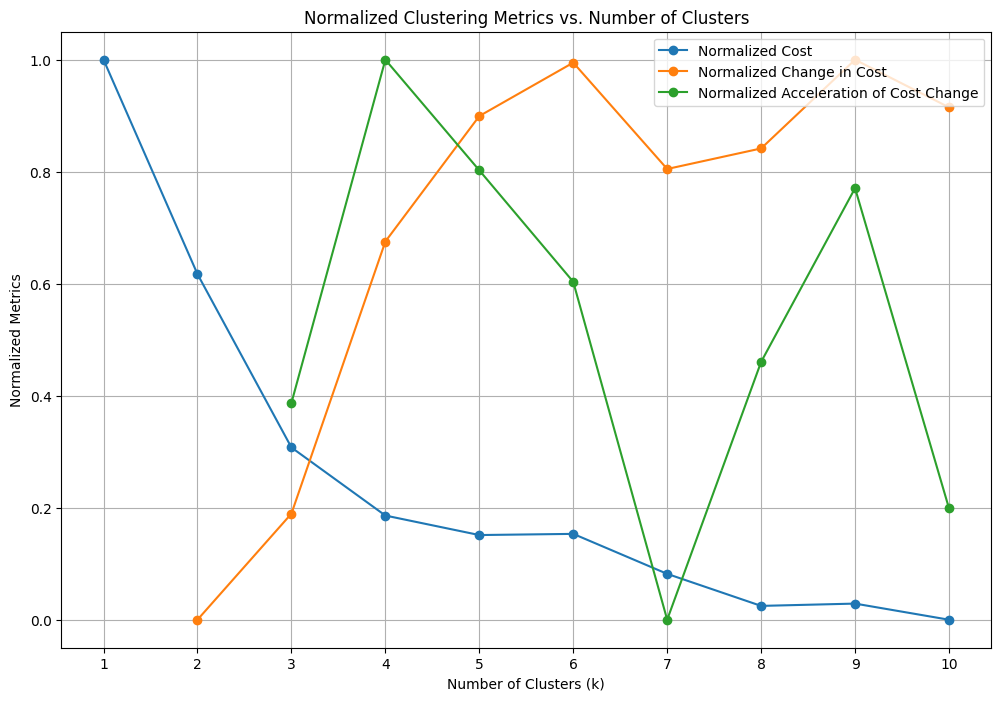

In [64]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the relevant columns
normalized_data = scaler.fit_transform(kmodes_cost[['cost', 'change_in_cost', 'change_in_cost_acceleration']])

# Create a new DataFrame with the normalized data
normalized_kmodes_cost = pd.DataFrame(normalized_data, columns=['cost', 'change_in_cost', 'change_in_cost_acceleration'])
normalized_kmodes_cost['k'] = kmodes_cost['k']

# Plot all normalized lines on a single graph
plt.figure(figsize=(12, 8))

# Plot normalized Cost vs. Number of Clusters
plt.plot(normalized_kmodes_cost['k'], normalized_kmodes_cost['cost'], marker='o', label='Normalized Cost')

# Plot normalized Change in Cost vs. Number of Clusters
plt.plot(normalized_kmodes_cost['k'], normalized_kmodes_cost['change_in_cost'], marker='o', label='Normalized Change in Cost')

# Plot normalized Acceleration of Cost Change vs. Number of Clusters (Second Derivative)
plt.plot(normalized_kmodes_cost['k'], normalized_kmodes_cost['change_in_cost_acceleration'], marker='o', label='Normalized Acceleration of Cost Change')

# Set titles and labels
plt.title('Normalized Clustering Metrics vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Normalized Metrics')

# Set xticks to display all 'k' values
plt.xticks(normalized_kmodes_cost['k'])

plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### KModes: Creating the Clusters

In [65]:
#Deciding on the number of clusters
optimal_clusters = 4

# Perform KModes clustering
km = KModes(n_clusters=optimal_clusters, init='Huang', n_init=5, verbose=0)  # Change the number of clusters as needed
clusters = km.fit_predict(cat_profile_clean)

# Add the cluster labels to your new DataFrame
cat_profile_clean['kmodes_cluster'] = clusters

# Save to .csv
cat_profile_clean.to_csv(r'data\04_fct\fct_profile_kmodes_cluster.csv', index=True)

# Pickle the cleaned data
cat_profile_clean.to_pickle(r'data\04_fct\fct_profile_kmodes_cluster.pkl')

cat_profile_clean.head()

,gender,age_group,income_group,member_since,kmodes_cluster
customer_id,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,2017 Q3,0
78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,2017 Q2,2
e2127556f4f64592b11af22de27a7932,M,65-74,50K-74K,2018 Q2,3
389bc3fa690240e798340f5a15918d5c,M,65-74,50K-74K,2018 Q1,3
2eeac8d8feae4a8cad5a6af0499a211d,M,55-64,50K-74K,2017 Q4,3


### KModes: Understanding the Clusters

C:\Users\grant\AppData\Local\Temp\ipykernel_10048\3511112324.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = cat_profile_clean.groupby(['kmodes_cluster', category]).size().unstack()
C:\Users\grant\AppData\Local\Temp\ipykernel_10048\3511112324.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = cat_profile_clean.groupby(['kmodes_cluster', category]).size().unstack()


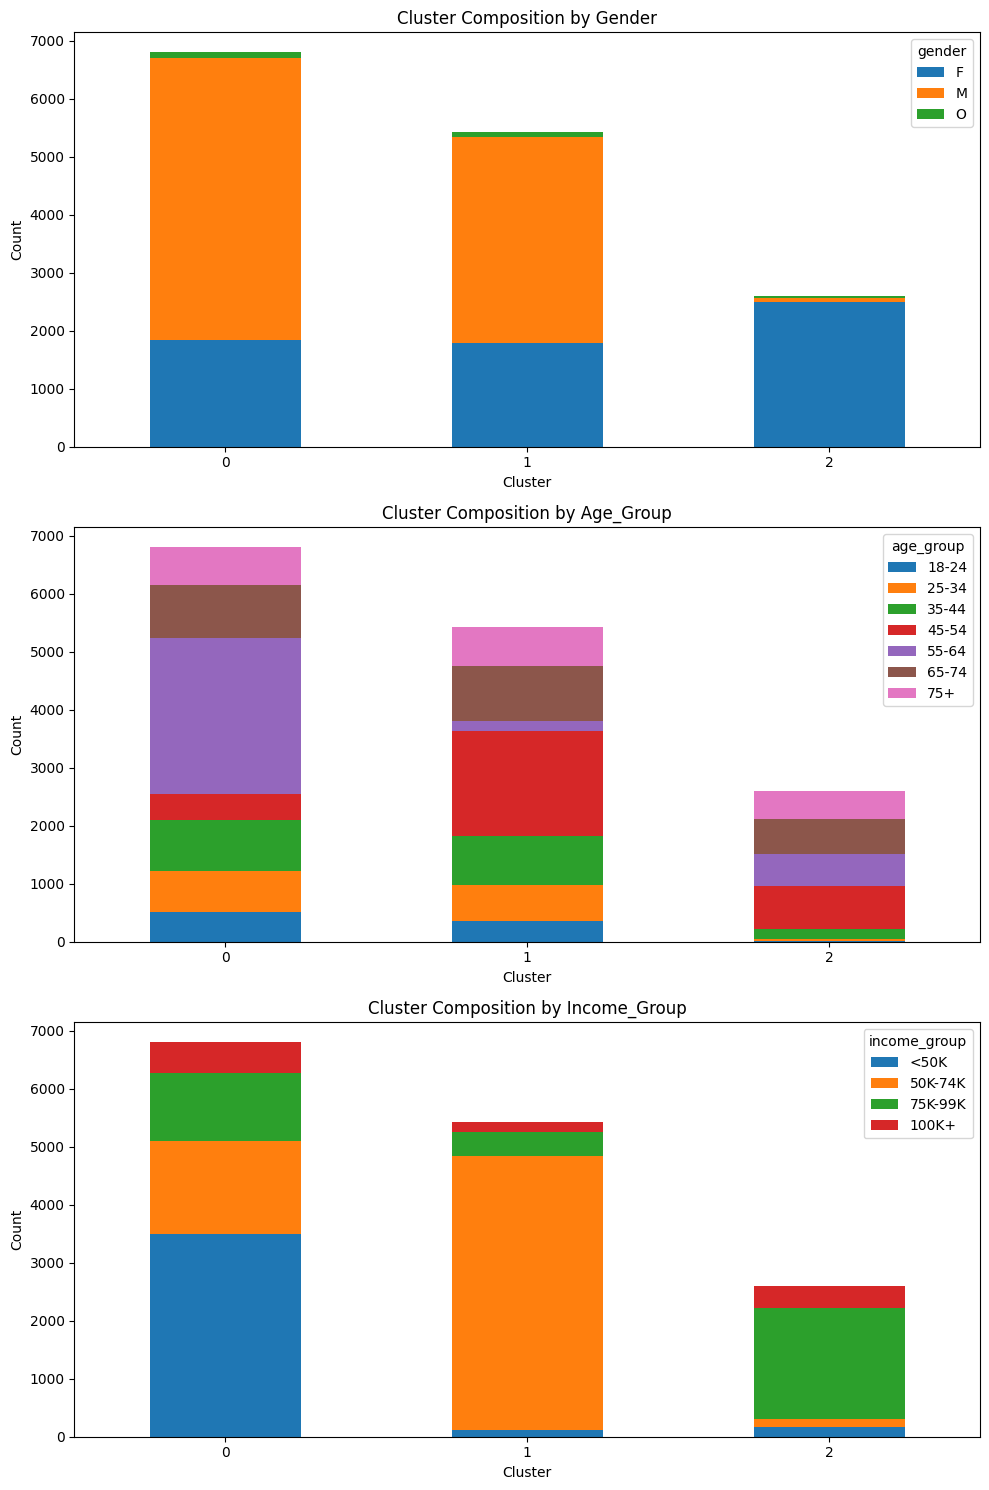

In [33]:
# List of categories
categories = ['gender', 'age_group', 'income_group']

# Create a subplot for each category
fig, axs = plt.subplots(len(categories), 1, figsize=(10, 15))

for i, category in enumerate(categories):
    # Create a grouped DataFrame
    grouped = cat_profile_clean.groupby(['kmodes_cluster', category]).size().unstack()

    # Create a stacked bar chart
    grouped.plot(kind='bar', stacked=True, ax=axs[i])

    # Set the title and labels
    axs[i].set_title(f'Cluster Composition by {category.title()}')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel('Customers')
    
    # Rotate the x-axis labels for each subplot
    for label in axs[i].get_xticklabels():
        label.set_rotation(0)

# Adjust the layout
plt.tight_layout()
plt.show()

In [71]:
# Exclude 'customer_id' from the columns
columns = [col for col in cat_profile_clean.columns if col != 'customer_id']

# Creating a dataframe to understand the cluster profiles
centroids_df = pd.DataFrame(km.cluster_centroids_, columns=columns)

# Count the number of customers in each cluster
num_customers = np.bincount(km.labels_)
centroids_df['num_customers'] = num_customers

#Calculate the percent of customers that are in these centroids
centroids_df['customer_percent'] = round(centroids_df['num_customers'] / centroids_df['num_customers'].sum() * 100, 2)

#Sort the dataframe by the number of customers in each cluster
centroids_df = centroids_df.sort_values('num_customers', ascending=False)

#The customer segements in the dataframe below are the centroids of the clusters
centroids_df.to_csv(r'data\04_fct\fct_profile_kmodes_centroids.csv', index=False)
centroids_df

,gender,age_group,income_group,member_since,kmodes_cluster,num_customers,customer_percent
3,M,45-54,50K-74K,2017 Q4,2,5006,33.77
0,M,55-64,<50K,2017 Q3,1,4722,31.85
2,F,65-74,75K-99K,2017 Q4,0,3483,23.49
1,M,55-64,50K-74K,2017 Q3,3,1614,10.89


### KPrototypes Clustering: Data Prep

In [48]:
#Import 'data\03_int\int_profile_clean.pkl'
profile_clean = pd.read_pickle(r'data\03_int\int_profile_clean.pkl')

#Drop 'became_member_on' column
profile_clean = profile_clean.drop('became_member_on', axis=1)

# Set 'customer_id' as the index
profile_clean = profile_clean.set_index('customer_id')

profile_clean.head()

,gender,age,income,days_as_member
customer_id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55.0,112000.0,376
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,100000.0,443
e2127556f4f64592b11af22de27a7932,M,68.0,70000.0,91
389bc3fa690240e798340f5a15918d5c,M,65.0,53000.0,167
2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,51000.0,257


### KProto: Determining the Clusters
Note: We cannot use the Silhouette score to help determine the optimal number of clusters because we cannot calculate Euclidean distances using categorical data. 

In [58]:
def calculate_cluster_costs(data, categorical_cols, max_clusters):
    """
    This function generates the cost for each number of clusters using the KProto algorithm.
    The cost is defined as the sum of the distances of all data points to their respective cluster centroids.
    The cost derivates are calculated to determine the optimal number of clusters.
    - First derivative (Rate of change): Change in Cost
    - Second derivative (Acceleration): Rate of Change of Change in Cost
    """
    np.random.seed(42)  # Set the seed outside the loop
    costs = []
    
    # Ensure categorical columns are at the beginning
    data = data[categorical_cols + [col for col in data.columns if col not in categorical_cols]]

    # Get the indices of the categorical columns
    categorical_indices = [data.columns.get_loc(col) for col in categorical_cols]

    # Calculate costs for each number of clusters
    for num_clusters in range(1, max_clusters+1):
        kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
        labels = kproto.fit_predict(data, categorical=categorical_indices)
        costs.append(kproto.cost_)
    
    # Create a DataFrame
    kprot_costs = pd.DataFrame({
        'k': range(1, max_clusters+1),
        'cost': costs
    })
    
    # Calculate the difference in costs and insert NaN at the beginning
    kprot_costs['change_in_cost'] = np.insert(np.diff(costs), 0, np.nan)
    
    # Calculate the percent change in cost
    kprot_costs['percent_change'] = kprot_costs['cost'].pct_change() * 100
    
    # Calculate the second derivative
    kprot_costs['change_in_cost_acceleration'] = kprot_costs['percent_change'].diff() / kprot_costs['k'].diff()

    return kprot_costs

In [59]:
# Define the data, categorical columns, and maximum number of clusters
data = profile_clean
categorical_cols = ['gender']
max_clusters = 10  

# Call the function
kproto_costs = calculate_cluster_costs(data, categorical_cols, max_clusters)

#Save to .csv
kproto_costs.to_csv(r'data\04_fct\fct_profile_kprototype_costs.csv', index=False)
kproto_costs

ValueError: could not convert string to float: 'F'

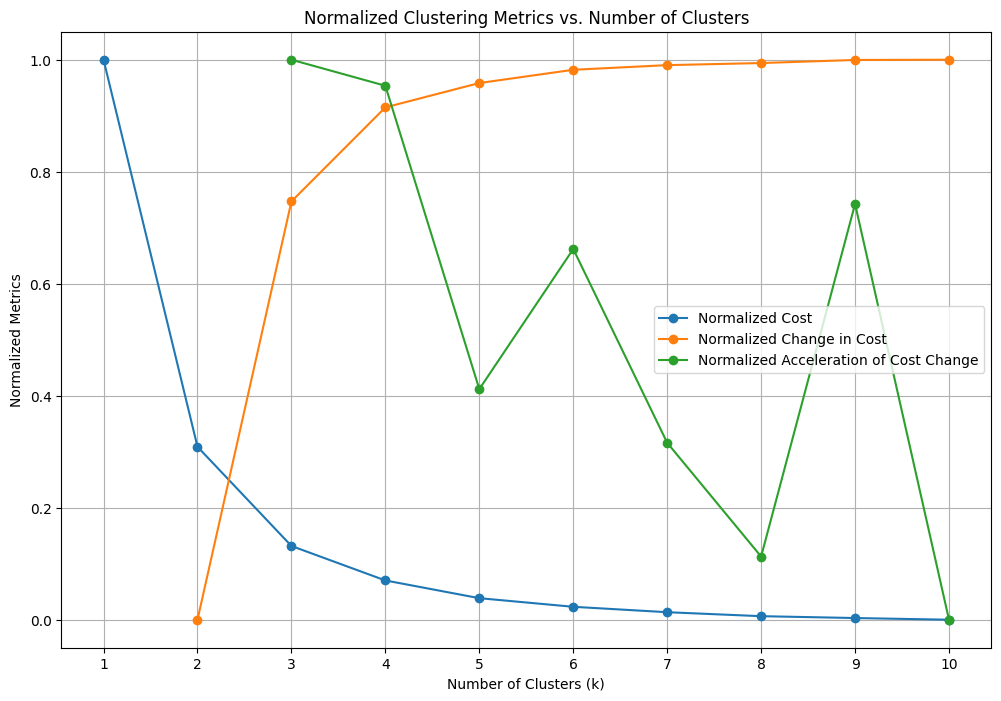

In [52]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the relevant columns
normalized_data = scaler.fit_transform(kproto_costs[['cost', 'change_in_cost', 'change_in_cost_acceleration']])

# Create a new DataFrame with the normalized data
normalized_kproto_costs = pd.DataFrame(normalized_data, columns=['cost', 'change_in_cost', 'change_in_cost_acceleration'])
normalized_kproto_costs['k'] = kproto_costs['k']

# Plot all normalized lines on a single graph
plt.figure(figsize=(12, 8))

# Plot normalized Cost vs. Number of Clusters
plt.plot(normalized_kproto_costs['k'], normalized_kproto_costs['cost'], marker='o', label='Normalized Cost')

# Plot normalized Change in Cost vs. Number of Clusters
plt.plot(normalized_kproto_costs['k'], normalized_kproto_costs['change_in_cost'], marker='o', label='Normalized Change in Cost')

# Plot normalized Acceleration of Cost Change vs. Number of Clusters (Second Derivative)
plt.plot(normalized_kproto_costs['k'], normalized_kproto_costs['change_in_cost_acceleration'], marker='o', label='Normalized Acceleration of Cost Change')

# Set titles and labels
plt.title('Normalized Clustering Metrics vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Normalized Metrics')

# Set xticks to display all 'k' values
plt.xticks(normalized_kproto_costs['k'])

plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### KProto:Creating the Clusters

In [70]:
#Deciding on the number of clusters
optimal_clusters = 4

categorical_cols = ['gender']

# Ensure categorical columns are at the beginning
data = data[categorical_cols + [col for col in data.columns if col not in categorical_cols]]

# Get the indices of the categorical columns
categorical_indices = [data.columns.get_loc(col) for col in categorical_cols]

# Perform KModes clustering
kproto = KPrototypes(n_clusters=optimal_clusters, init='Cao')
labels = kproto.fit_predict(profile_clean, categorical=categorical_indices)

# Add the cluster labels to your new DataFrame
profile_clean['kproto_cluster'] = clusters

# Save to .csv
profile_clean.to_csv(r'data\04_fct\fct_profile_kproto_cluster.csv', index=True)

# Pickle the cleaned data
profile_clean.to_pickle(r'data\04_fct\fct_profile_kproto_cluster.pkl')

profile_clean.head()

,gender,age,income,days_as_member,kmodes_cluster,kproto_cluster
customer_id,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55.0,112000.0,376,0,0
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,100000.0,443,2,2
e2127556f4f64592b11af22de27a7932,M,68.0,70000.0,91,3,3
389bc3fa690240e798340f5a15918d5c,M,65.0,53000.0,167,3,3
2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,51000.0,257,3,3


### KProto: Understanding the Clusters

In [73]:
# Creating a dataframe to understand the cluster profiles
centroids_df = pd.DataFrame(kproto.cluster_centroids_, columns=columns)

###TO DO###
# Figure out how to normalize the age, income and membership numbers in the centroids_df dataframer

# Count the number of customers in each cluster
num_customers = np.bincount(kproto.labels_)
centroids_df['num_customers'] = num_customers

#Calculate the percent of customers that are in these centroids
centroids_df['customer_percent'] = round(centroids_df['num_customers'] / centroids_df['num_customers'].sum() * 100, 2)

#Sort the dataframe by the number of customers in each cluster
centroids_df = centroids_df.sort_values('num_customers', ascending=False)

#The customer segements in the dataframe below are the centroids of the clusters
centroids_df.to_csv(r'data\04_fct\fct_profile_kproto_centroids.csv', index=False)
centroids_df

,gender,age_group,income_group,member_since,kmodes_cluster,num_customers,customer_percent
0,51.978794642857146,57407.58928571428,533.4441964285714,2.3658482142857142,M,4480,30.22
3,57.22324455205811,75515.98062953995,528.6910411622276,2.011138014527845,M,4130,27.86
1,48.03173289183223,39003.035320088304,497.6501103752759,0.2847682119205298,M,3624,24.45
2,62.956387495175605,100044.38440756465,528.345426476264,1.4129679660362795,F,2591,17.48


The cost gradient seems much smoother with KProto as compared KModes

# Transcript Data

In [429]:
"""
Event log (306648 events x 4 fields)
Logs all events related to offers and transactions, such as offer receipt, offer view, transaction amount, and offer completion, along with timestamps
    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    person (str) - customer id
    time (int) - time in hours since start of test. The data begins at time t=0
    value - (dict of strings) - either an offer id or transaction amount depending on the record

"""
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
